In [300]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sys

# Visualising the model

In [394]:
def visualise_ambulance_markov_chain(threshold, parking_capacity, system_capacity):

    states_1 = [(0,v) for v in range(0, threshold)]
    states_2 = [(u,v) for v in range(threshold, system_capacity+1) for u in range(0, parking_capacity+1)]
    all_states = states_1 + states_2

    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            column_adjacent = (destination_state[0] - origin_state[0] == 1 and destination_state[1] - origin_state[1] == 0)
            row_adjacent = (destination_state[1] - origin_state[1] == 1 and destination_state[0] - origin_state[0] == 0)
            if row_adjacent or column_adjacent:
                G.add_edge(origin_state, destination_state)

    plt.figure(figsize=(1.5 * (parking_capacity+1), 1.5 * system_capacity))
    pos = {state:list(state) for state in all_states}
    nx.draw_networkx_nodes(G, pos, node_size=2000)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off');

# Getting individual entrys of the transition matrix (Symbolic/Exact)

In [435]:
def get_symbolic_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, mu, num_of_servers):
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return "L"
        return "l_o"
    elif row_diff == -1 and column_diff == 0:
        return "l_a"
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return (str(origin[1]) + "mu")
        else:
            return (str(num_of_servers) + "mu")
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return (str(threshold) + "mu")
    else:
        return "0"

In [436]:
def get_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, mu, num_of_servers):
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return lambda_a + lambda_o
        return lambda_o
    elif row_diff == -1 and column_diff == 0:
        return lambda_a
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0

# Get the whole transition matrix (Symbolic/Exact)

In [437]:
def get_symbolic_transition_matrix(lambda_a, lambda_o, mu, number_of_servers, threshold, system_capacity, parking_capacity):
    states_1 = [(0,v) for v in range(0, threshold)]
    states_2 = [(u,v) for v in range(threshold, system_capacity+1) for u in range(parking_capacity+1)]
    all_states = states_1 + states_2

    np.set_printoptions(threshold=sys.maxsize)
    Q = np.zeros((len(all_states),len(all_states)), dtype="<U5")
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i,j] = get_symbolic_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers)
    return Q

In [438]:
def get_transition_matrix(lambda_a, lambda_o, mu, number_of_servers, threshold, system_capacity, parking_capacity):
    states_1 = [(0,v) for v in range(0, threshold)]
    states_2 = [(u,v) for v in range(threshold, system_capacity+1) for u in range(parking_capacity+1)]
    all_states = states_1 + states_2

    np.set_printoptions(threshold=sys.maxsize)
    Q = np.zeros((len(all_states),len(all_states)))
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i,j] = get_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers)
    return Q

In [458]:
lambda_a = 0.4
lambda_o = 0.3
mu = 0.4
num_of_servers = 8
threshold = 4
system_capacity = 20
parking_capacity = 5

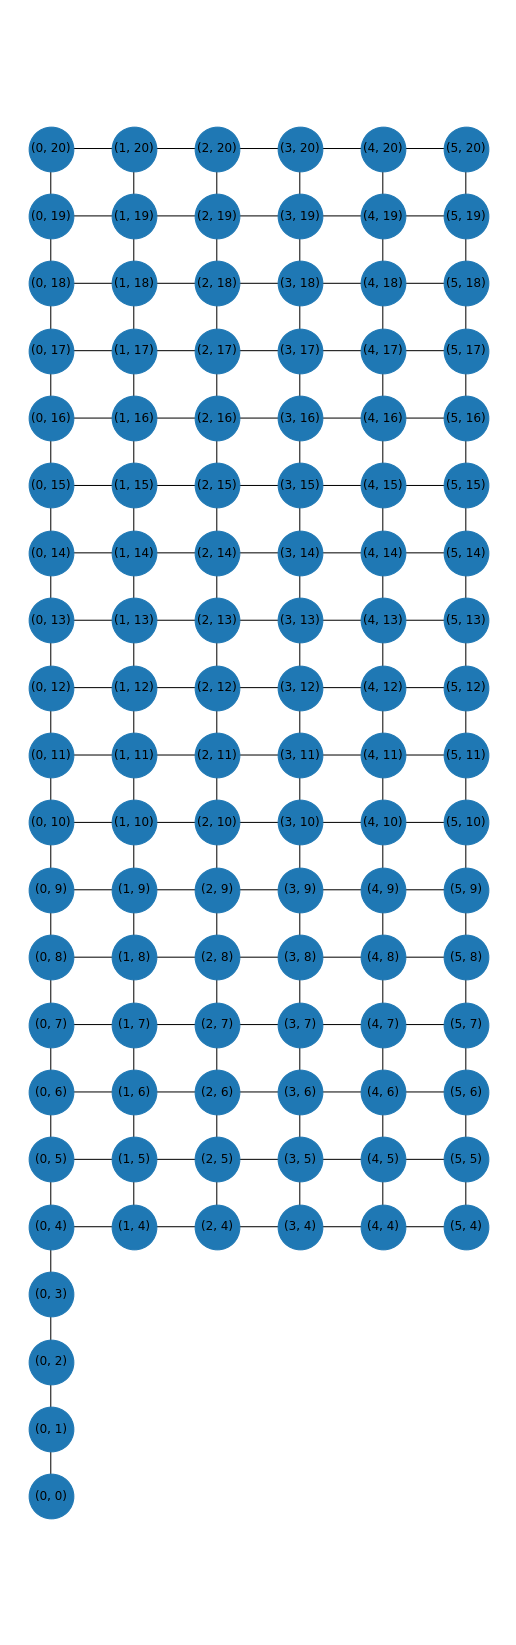

In [459]:
visualise_ambulance_markov_chain(threshold, parking_capacity, system_capacity)

In [460]:
Q_sym = get_symbolic_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

In [461]:
Q = get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

In [463]:
Q_sym

array([['0', 'L', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0'],
       ['1mu', '0', 'L', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0

In [464]:
Q

array([[0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.4, 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ,

# Dummy Cells